In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from random import randint
import os
import pathlib
import torch
from torch import nn
import matplotlib.gridspec as gridspec
import torch.nn.functional as F
import pathlib
from torch.utils.data import DataLoader
from torchvision import *
from torch.utils.data import SubsetRandomSampler
from sklearn.utils import shuffle
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
transformtrain = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])
transformtest = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])
train_data = datasets.ImageFolder('../input/intel-image-classification/seg_train/seg_train', transform=transformtrain)
test_data = datasets.ImageFolder('../input/intel-image-classification/seg_test/seg_test', transform=transformtest)
root = pathlib.Path('../input/intel-image-classification/seg_train/seg_train')
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])


In [15]:
num_workers = 0
valid_size = 0.3

n_train = len(train_data)
indices = list(range(n_train))
np.random.shuffle(indices)
indices_test = list(range(len(test_data)))
valid_split = int(np.floor((valid_size) * n_train))
valid_idx = indices[:valid_split]
train_idx = indices[valid_split:]
test_idx = indices_test

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=100, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, 
    sampler=test_sampler, num_workers=num_workers)


In [16]:
class convnet(nn.Module):
    def __init__(self):
        super(convnet,self).__init__()
         # sees 150*150*3
        self.conv1 = nn.Conv2d(3,64,kernel_size=(3,3))
        self.conv2 = nn.Conv2d(64,200,kernel_size=(3,3))
        self.conv3 = nn.Conv2d(200,140,kernel_size=(3,3))
        self.conv4 = nn.Conv2d(140,100,kernel_size=(3,3))
        self.conv5 = nn.Conv2d(100,50,kernel_size=(3,3))
        self.conv6 = nn.Conv2d(50,25,kernel_size=(3,3))
        # sees  
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(25600, 50)
        self.fc2 = nn.Linear(50 , 6)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))
        x = (F.relu(self.conv4(x)))
        x = (F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = x.view(-1, 25600)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
        

In [17]:
model = convnet()
print(model)
# param.requires_grad = False

convnet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 200, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(200, 140, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(140, 100, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(100, 50, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(50, 25, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25600, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=6, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [18]:
import torch.optim as optim
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [19]:
def train(n_epochs, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [20]:
train(50, model, optimizer, criterion,use_cuda, 'image_classify.pt')

Epoch 1, Batch 1 loss: 1.790134
Epoch: 1 	Training Loss: 1.791880 	Validation Loss: 1.792496
Validation loss decreased (inf --> 1.792496).  Saving model ...
Epoch 2, Batch 1 loss: 1.798295
Epoch: 2 	Training Loss: 1.791212 	Validation Loss: 1.791738
Validation loss decreased (1.792496 --> 1.791738).  Saving model ...
Epoch 3, Batch 1 loss: 1.793711
Epoch: 3 	Training Loss: 1.790048 	Validation Loss: 1.790164
Validation loss decreased (1.791738 --> 1.790164).  Saving model ...
Epoch 4, Batch 1 loss: 1.788742
Epoch: 4 	Training Loss: 1.784726 	Validation Loss: 1.773881
Validation loss decreased (1.790164 --> 1.773881).  Saving model ...
Epoch 5, Batch 1 loss: 1.766405
Epoch: 5 	Training Loss: 1.665441 	Validation Loss: 1.442232
Validation loss decreased (1.773881 --> 1.442232).  Saving model ...
Epoch 6, Batch 1 loss: 1.410807
Epoch: 6 	Training Loss: 1.347841 	Validation Loss: 1.445957
Epoch 7, Batch 1 loss: 1.562982
Epoch: 7 	Training Loss: 1.219791 	Validation Loss: 1.143261
Validatio

convnet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 200, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(200, 140, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(140, 100, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(100, 50, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(50, 25, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25600, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=6, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [21]:
model.load_state_dict(torch.load('image_classify.pt'))

<All keys matched successfully>

In [22]:
def test(model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
test(model, criterion, use_cuda)

Test Loss: 0.762181


Test Accuracy: 74% (2242/3000)


In [23]:
def load_input_image(img_path):    
    image = Image.open(img_path)
    prediction_transform = transforms.Compose([
                            transforms.Resize((150, 150)),
                            transforms.ToTensor(),
                            transforms.Normalize((.5, .5, .5), (.5, .5, .5))
                            ])
    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image).unsqueeze(0)
    return image

In [45]:
def predict_location(model,img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return idx

Sea


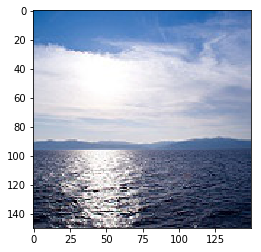

forest


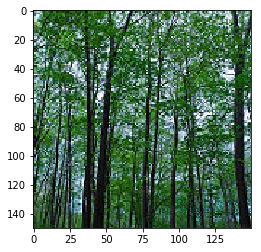

forest


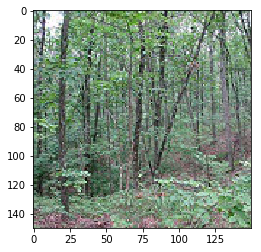

forest


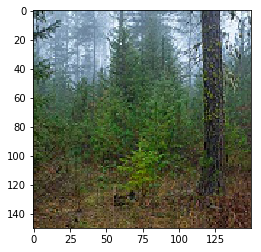

Street


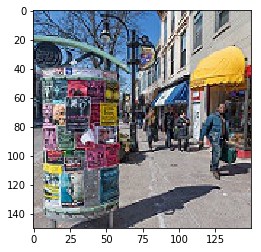

glacier


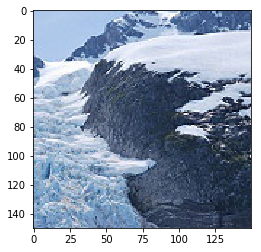

forest


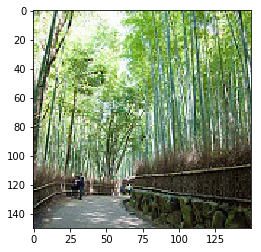

building


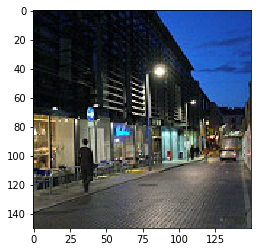

building


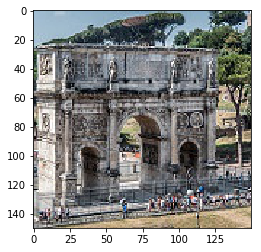

glacier


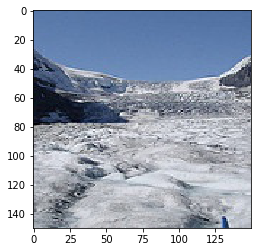

In [47]:
from glob import glob
from PIL import Image
from termcolor import colored

ims = np.array(glob("../input/intel-image-classification/seg_pred/seg_pred/*"))
for i in range(10,20):
    img_path=ims[i]
    img = Image.open(img_path)
    if predict_location(model, img_path) == 0:
        print(colored('building', 'green'))
    elif predict_location(model, img_path) == 1:
         print(colored('forest', 'green'))
    elif predict_location(model, img_path) == 2:
         print(colored('glacier', 'green'))
    elif predict_location(model, img_path) == 3:
         print(colored('mountain', 'green'))
    elif predict_location(model, img_path) == 4:
         print(colored('Sea', 'green'))
    elif predict_location(model, img_path) == 5:
         print(colored('Street', 'green'))
        
    plt.imshow(img)
    plt.show()